In [1]:
!pip install mplcyberpunk

In [2]:
import kagglehub
import warnings
import polars as pl
import polars.selectors as cs
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from keras import layers, Model, optimizers, losses, metrics, callbacks

import matplotlib.pyplot as plt
import mplcyberpunk

warnings.filterwarnings('ignore')
plt.style.use('cyberpunk')

2025-08-19 16:57:08.677439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755622628.916064      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755622628.989365      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pl.read_csv('/kaggle/input/google-daily-stock-prices-2004-today/googl_daily_prices.csv')
df

date,1. open,2. high,3. low,4. close,5. volume
str,f64,f64,f64,f64,f64
"""2025-08-18""",204.2,205.25,202.49,203.5,1.8476092e7
"""2025-08-15""",203.85,206.44,201.28,203.9,3.4931422e7
"""2025-08-14""",201.5,204.44,201.225,202.94,2.5230427e7
"""2025-08-13""",204.13,204.53,197.5101,201.96,2.8342922e7
"""2025-08-12""",201.365,204.5,200.59,203.34,3.0424452e7
…,…,…,…,…,…
"""2004-08-25""",104.76,108.0,103.88,106.0,9.1886e6
"""2004-08-24""",111.24,111.6,103.57,104.87,1.52473e7
"""2004-08-23""",110.76,113.48,109.05,109.4,1.82561e7


In [4]:
df.null_count()

date,1. open,2. high,3. low,4. close,5. volume
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


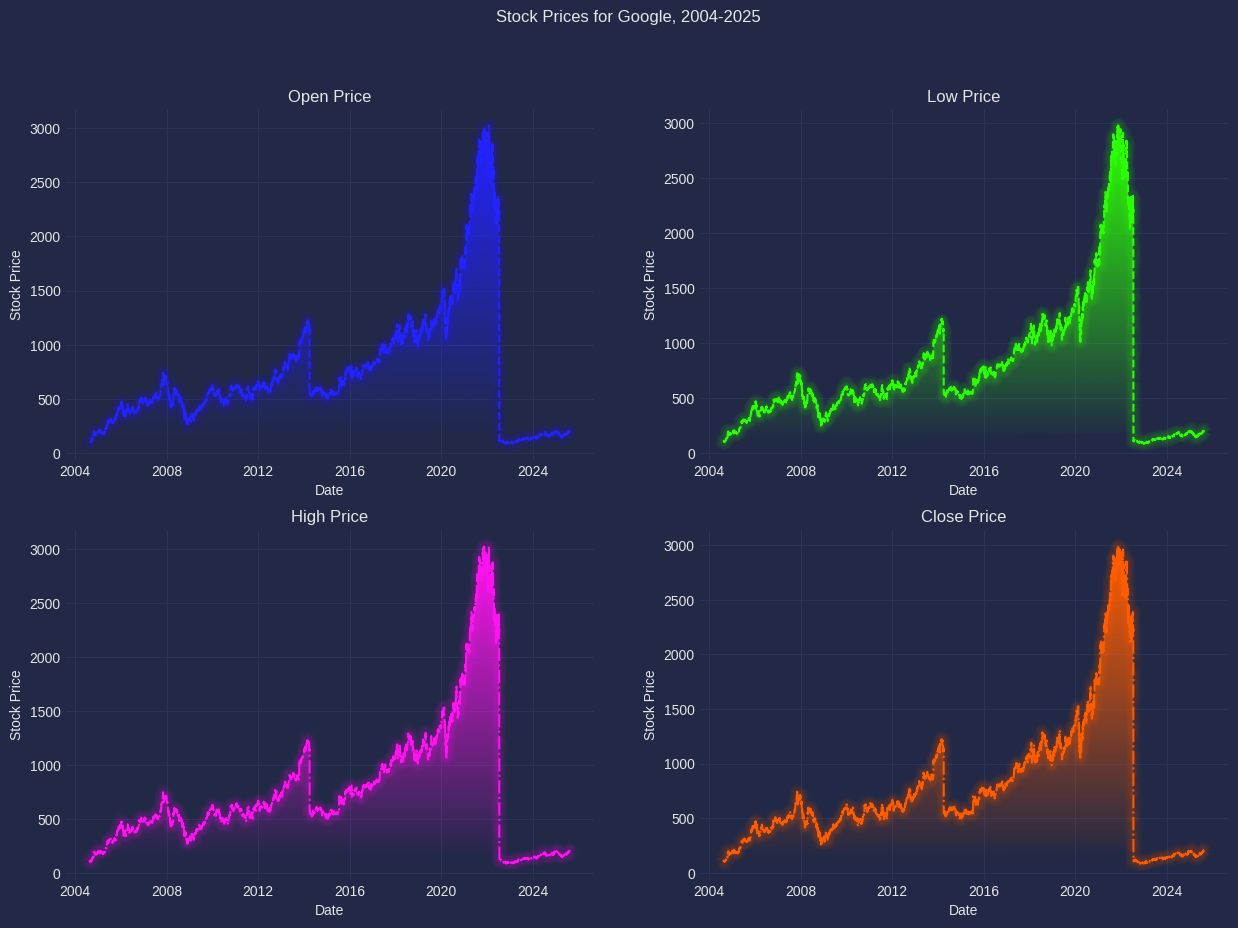

In [5]:
df = df.with_columns(
    pl.col('date').str.to_date(),
).rename({'date' : 'Date', '1. open' : 'Open', '2. high' : 'High', '3. low' : 'Low', '4. close' : 'Close'}).drop('5. volume')

plot_dates = df.select('Date')
num_vals = df.select(cs.numeric())
colors = ['#2323FF', '#FF13F0', '#2CFF05', '#FF5C00', '#FF073A']
linestyles = ['--', '-.', '--', '-.']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Stock Prices for Google, 2004-2025')

for idx, col in enumerate(num_vals):
    axes = ax[idx % 2, idx // 2]
    axes.set_title(f'{col.name} Price')
    axes.set_xlabel('Date')
    axes.set_ylabel('Stock Price')
    axes.plot(plot_dates, num_vals.select(col), color=colors[idx], linestyle=linestyles[idx])
    mplcyberpunk.make_lines_glow(ax=axes)
    mplcyberpunk.add_gradient_fill(ax=axes)

In [6]:
df = df.select(['Date', 'Open', 'Close']).reverse()
df

Date,Open,Close
date,f64,f64
2004-08-19,100.01,100.335
2004-08-20,101.01,108.31
2004-08-23,110.76,109.4
2004-08-24,111.24,104.87
2004-08-25,104.76,106.0
…,…,…
2025-08-12,201.365,203.34
2025-08-13,204.13,201.96
2025-08-14,201.5,202.94


In [7]:
scaler = MinMaxScaler()

scaled_df = pl.DataFrame(scaler.fit_transform(df.select(['Close', 'Open']))).rename({'column_0' : 'Close', 'column_1' : 'Open'})
scaled_df = scaled_df.select(['Open', 'Close'])
train_size = int(len(df) * 0.8)

train_df = scaled_df[:train_size]
test_df = scaled_df[train_size:]

In [8]:
def create_multi_time_series_ds(seq, seq_length):
    x, y = [], []
    
    for i in range(len(seq) - seq_length):
        x.append(seq[i:i+seq_length])
        y.append(seq[i+1:i+seq_length+1][-1])
        
    return np.array(x), np.array(y)

x_train, y_train = create_multi_time_series_ds(train_df.to_numpy(), 24)
x_test, y_test = create_multi_time_series_ds(test_df.to_numpy(), 24)

In [9]:
inputs = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
x = layers.LSTM(units=50, return_sequences=True)(inputs)
x = layers.LSTM(units=50, return_sequences=True)(x)
x = layers.LSTM(units=50)(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(units=2)(x)

model = Model(inputs, outputs)
model.summary()

2025-08-19 16:57:27.037534: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,302 (200.40 KB)

 Trainable params: 51,202 (200.01 KB)

 Non-trainable params: 100 (400.00 B)

In [10]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.MeanSquaredError(),
    metrics=[metrics.MeanSquaredError()]
)

early_stopping = callbacks.EarlyStopping(
    patience=20
)

lr_on_plateau = callbacks.ReduceLROnPlateau(
    patience=5
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_on_plateau]
)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0382 - mean_squared_error: 0.0382 - val_loss: 0.0782 - val_mean_squared_error: 0.0782 - learning_rate: 0.0010
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0700 - val_mean_squared_error: 0.0700 - learning_rate: 0.0010
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.6047e-04 - mean_squared_error: 8.6047e-04 - val_loss: 0.0630 - val_mean_squared_error: 0.0630 - learning_rate: 0.0010
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.7906e-04 - mean_squared_error: 9.7906e-04 - val_loss: 0.0493 - val_mean_squared_error: 0.0493 - learning_rate: 0.0010
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.4810e-04 - mean_squared_error: 7.4810e-04 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - learning_rate: 0.0010
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0

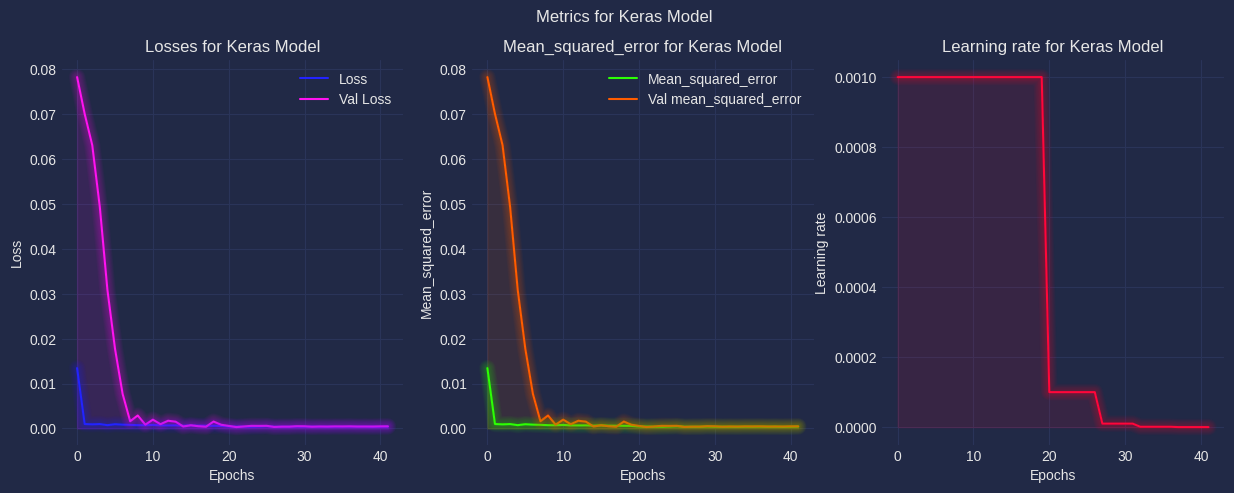

In [11]:
def plot_keras_metrics(hist, metric, colors):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(f'Metrics for Keras Model')
    ax[0].set_title(f'Losses for Keras Model')
    ax[0].set_ylabel(f'Loss')
    ax[0].plot(hist['loss'], color=colors[0], label='Loss')
    ax[0].plot(hist['val_loss'], color=colors[1], label='Val Loss')
    
    ax[1].set_title(f'{metric.capitalize()} for Keras Model')
    ax[1].set_ylabel(f'{metric.capitalize()}')
    ax[1].plot(hist[metric], color=colors[2], label=metric.capitalize())
    ax[1].plot(hist['val_'+metric], color=colors[3], label='Val ' + metric)

    ax[2].set_title(f'Learning rate for Keras Model')
    ax[2].set_ylabel(f'Learning rate')
    ax[2].plot(hist['learning_rate'], colors[4])

    for i in range(3):
        axes = ax[i]
        axes.set_xlabel('Epochs')
        axes.legend()
        mplcyberpunk.make_lines_glow(ax=axes)
        mplcyberpunk.add_underglow(ax=axes)

plot_keras_metrics(
    hist=history.history,
    metric='mean_squared_error',
    colors=colors
)

In [12]:
evals = model.evaluate(x_test, y=y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038


In [13]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

actual_train = df[:train_size-24]
actual_test = df[train_size:-24]

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [14]:
def get_open_close(preds):
    open_p = []
    close_p = []

    for i in range(len(preds)):
        open_p.append(preds[i][0]), close_p.append(preds[i][1])
    
    return open_p, close_p

open_train_pred, close_train_pred = get_open_close(train_predict)
open_test_pred, close_test_pred = get_open_close(test_predict)

In [15]:
def forecast_multivariate(model, sequence, sequence_length, time):
    last_sequence = sequence[-1]
    last_sequence = last_sequence.reshape((1, sequence_length, 2))
    preds = []

    for _ in range(time):
        current_pred = model.predict(last_sequence, verbose=0)
        preds.append(current_pred)
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = current_pred

    return np.array(preds)

forecasts = forecast_multivariate(model, x_test, 24, 30)
forecasts = forecasts.reshape(forecasts.shape[0], forecasts.shape[-1])
forecasts = scaler.inverse_transform(forecasts)

In [16]:
actual_train = actual_train.insert_column(1, pl.Series("Predicted Open", open_train_pred))
actual_train = actual_train.insert_column(-1, pl.Series("Predicted Close", close_train_pred))
actual_test = actual_test.insert_column(1, pl.Series("Predicted Open", open_test_pred))
actual_test = actual_test.insert_column(-1, pl.Series("Predicted Close", close_test_pred))

In [17]:
open_forecasts, closes_forecasts = get_open_close(forecasts)
actual_forecasts = df[len(df)-30:]

actual_forecasts = actual_forecasts.insert_column(1, pl.Series('Predicted Open', open_forecasts))
actual_forecasts = actual_forecasts.insert_column(-1, pl.Series('Predicted Close', closes_forecasts))

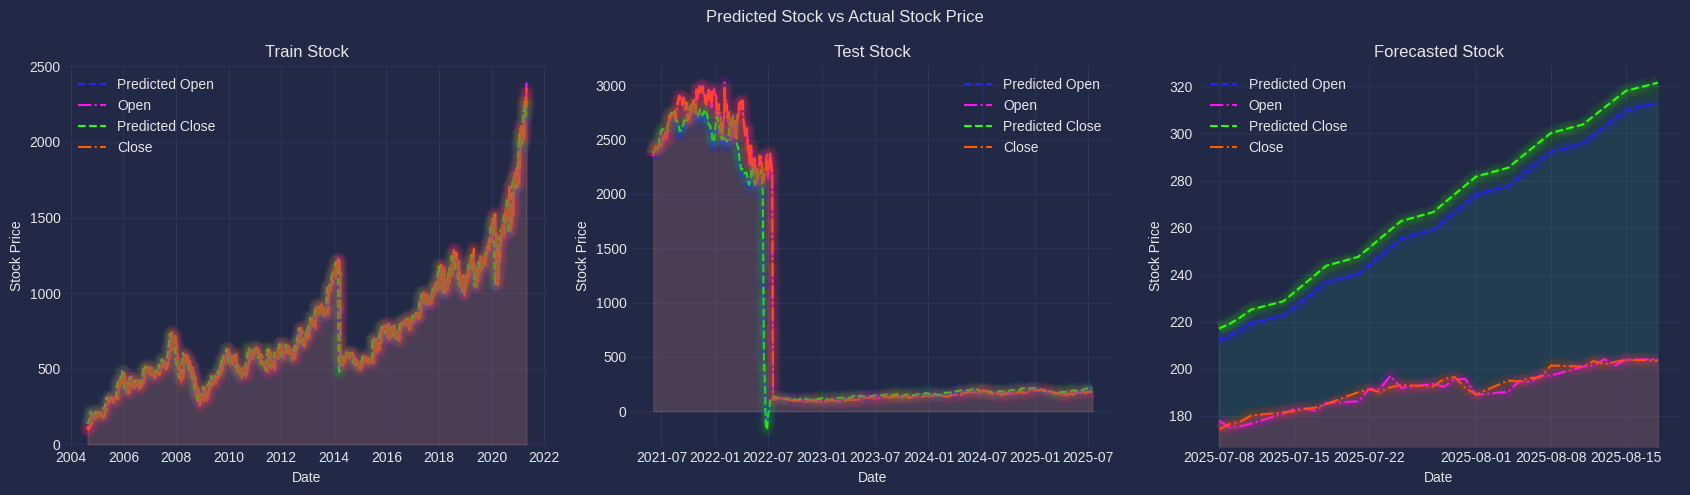

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))
fig.suptitle('Predicted Stock vs Actual Stock Price')

def plot_stock_preds(ax, idx, title, df, colors, linestyles):
    ax[idx].set_title(title)
    ax[idx].set_xlabel('Date')
    ax[idx].set_ylabel('Stock Price')
    labels = df.columns[1:]

    for y, color, label, style in zip(df.select(cs.numeric()), colors, labels, linestyles):
        ax[idx].plot(df.select('Date'), y, label=label, color=color, linestyle=style)

    ax[idx].legend()
    mplcyberpunk.make_lines_glow(ax=ax[idx])
    mplcyberpunk.add_underglow(ax=ax[idx])

plot_stock_preds(ax, 0, 'Train Stock', actual_train, colors, linestyles)
plot_stock_preds(ax, 1, 'Test Stock', actual_test, colors, linestyles)
plot_stock_preds(ax, 2, 'Forecasted Stock', actual_forecasts, colors, linestyles)
plt.tight_layout()